## Analyse FF Lymph Node with scGCO

In [1]:
#import scanpy as sc
from math import gcd
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
#import scanorama
import csv
import dill
from sklearn.metrics.pairwise import cosine_distances
from scGCO import *
import scanpy as sc

%matploblib inline

/opt/anaconda3/envs/scGCO_scanpy/lib/python3.7/site-packages/pysal/lib/weights/util.py:19: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')
UsageError: Line magic function `%matploblib` not found.


In [ ]:
#load in dataset
ff_human_lymph_node = sc.datasets.visium_sge('V1_Human_Lymph_Node')
ff_human_lymph_node.var_names_make_unique()

#Calculate some QC metrics for the data
#Calculate some QC metrics for the data
ff_human_lymph_node.var["mt"] = ff_human_lymph_node.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(ff_human_lymph_node, qc_vars=["mt"], inplace=True)

#Perform some filtering
sc.pp.filter_cells(ff_human_lymph_node, min_counts=5000)
sc.pp.filter_cells(ff_human_lymph_node, max_counts=35000)
ff_human_lymph_node = ff_human_lymph_node[ff_human_lymph_node.obs["pct_counts_mt"] < 4]
ff_human_lymph_node = ff_human_lymph_node[ff_human_lymph_node.obs["pct_counts_mt"] > 0.5]
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(ff_human_lymph_node, min_cells=10)
sc.pp.filter_cells(ff_human_lymph_node, min_genes = 3000)

##Do normalisation and find highly variable genes
sc.pp.normalize_total(ff_human_lymph_node, inplace=True)
sc.pp.log1p(ff_human_lymph_node)
sc.pp.highly_variable_genes(ff_human_lymph_node, flavor="seurat", n_top_genes=2000)

#Perform next steps in cluster identification
sc.pp.pca(ff_human_lymph_node,n_comps=20)
sc.pp.neighbors(ff_human_lymph_node)
sc.tl.umap(ff_human_lymph_node)
sc.tl.leiden(ff_human_lymph_node, key_added='clusters')

In [10]:
#read dataframe of preprocessed counts back into scGCO 
norm_counts = pd.read_csv('X.csv',header=None)
norm_counts.head()

,0,1,2,3,4,5,6,7,8,9,...,19446,19447,19448,19449,19450,19451,19452,19453,19454,19455
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.070827,1.070827,0.000000,...,4.249074,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
1,0.0,0.0,0.618459,0.356298,0.0,0.0,0.356298,0.618459,0.356298,0.000000,...,4.340706,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,3.734931,0.0,0.0,0.0,0.0,0.0,0.70415,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.642542,1.309393,0.000000,...,4.247782,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.075342,1.075342,...,3.877625,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,1.075342,0.0


In [11]:
##need to add in gene names and cell types
obs_norm_counts = pd.read_csv('obs.csv')
norm_counts_barcodes = obs_norm_counts["Unnamed: 0"]

#add this column as index to norm_counts
norm_counts.index = norm_counts_barcodes
norm_counts

,0,1,2,3,4,5,6,7,8,9,...,19446,19447,19448,19449,19450,19451,19452,19453,19454,19455
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.070827,1.070827,0.000000,...,4.249074,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.618459,0.356298,0.0,0.0,0.356298,0.618459,0.356298,0.000000,...,4.340706,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,3.734931,0.0,0.0,0.000000,0.000000,0.0,0.70415,0.0,0.000000,0.0
AAACAGTGTTCCTGGG-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.642542,1.309393,0.000000,...,4.247782,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
AAACCCGAACGAAATC-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.075342,1.075342,...,3.877625,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,1.075342,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.162047,0.000000,...,4.802428,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.793125,0.000000,...,4.138759,0.0,0.0,0.000000,0.793125,0.0,0.00000,0.0,0.793125,0.0
TTGTTTCACATCCAGG-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.469328,0.749262,0.749262,...,4.411913,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0


In [12]:
##get gene names
var_norm_counts = pd.read_csv('var.csv')
var_genes = list(var_norm_counts["Unnamed: 0"])

#add these as column names
norm_counts.columns = var_genes
norm_counts

,AL627309.1,AP006222.2,LINC01409,LINC01128,LINC00115,FAM41C,LINC02593,SAMD11,NOC2L,KLHL17,...,MT-CYB,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1,AC007325.4,AC007325.2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.070827,1.070827,0.000000,...,4.249074,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.618459,0.356298,0.0,0.0,0.356298,0.618459,0.356298,0.000000,...,4.340706,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,3.734931,0.0,0.0,0.000000,0.000000,0.0,0.70415,0.0,0.000000,0.0
AAACAGTGTTCCTGGG-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.642542,1.309393,0.000000,...,4.247782,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
AAACCCGAACGAAATC-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.075342,1.075342,...,3.877625,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,1.075342,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.162047,0.000000,...,4.802428,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.793125,0.000000,...,4.138759,0.0,0.0,0.000000,0.793125,0.0,0.00000,0.0,0.793125,0.0
TTGTTTCACATCCAGG-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.469328,0.749262,0.749262,...,4.411913,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0


In [14]:
array_row = list(ff_human_lymph_node.obs["array_row"])
array_col = list(ff_human_lymph_node.obs["array_col"])
locs = np.column_stack((array_col,array_row))
locs

array([[102,  50],
       [ 19,  59],
       [ 13,  47],
       ...,
       [ 42,  58],
       [ 30,  60],
       [ 27,  45]])

In [15]:
#begin scGCO processing for determing presence of SVGs
#create graph connecting space and spots
exp= norm_counts.iloc[:,0]
cellGraph= create_graph_with_weight(locs, exp)

<IPython.core.display.Javascript object>


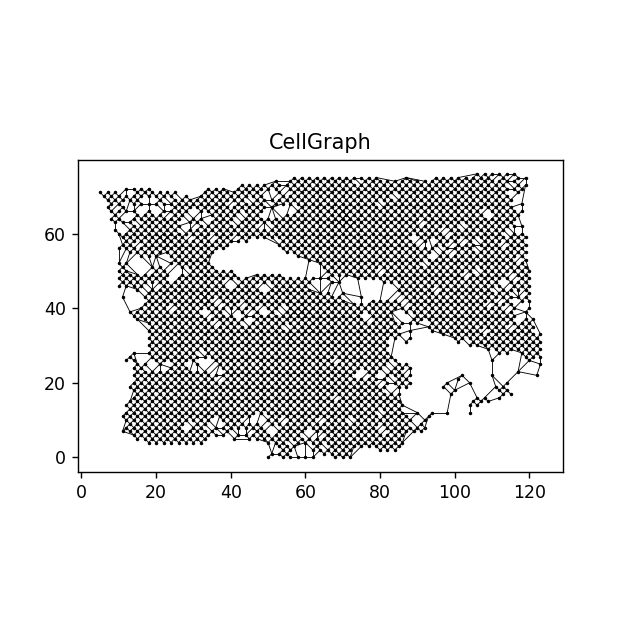

Text(0.5, 1.0, 'CellGraph')

In [16]:
#Look at graph
fig, ax= plt.subplots(1,1,figsize=(5,5)) #, dpi=300)
ax.set_aspect('equal')

exp= norm_counts.iloc[:,0].values
cellGraph = create_graph_with_weight(locs, exp)
ax.scatter(locs[:,0], locs[:,1], s=1, color='black')
for i in np.arange(cellGraph.shape[0]):
    x = (locs[int(cellGraph[i,0]), 0], locs[int(cellGraph[i,1]), 0]) 
    y = (locs[int(cellGraph[i,0]), 1], locs[int(cellGraph[i,1]), 1])     
    ax.plot(x, y, color='black', linewidth=0.5)
    
plt.title('CellGraph')

In [17]:
#Skip to step 2: Gene expression processing with Gaussian mixture modelling
output_dir = 'scGCO_outputs/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir) 
    
import time
t0 = time.time()
gmmDict=multiGMM(norm_counts)
t1= time.time()
print(t1-t0, ' second')

# # save gmm results
fileName=os.path.join(output_dir,"ff_lymph_node_scanpy_scgco_gmmDict.pkl")




store_gmm(gmmDict,fileName)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:40<00:00, 27.50s/it]


220.8942358493805  second


In [ ]:
#Run main function to identify SVGs
t0= time.time()
result_df= identify_spatial_genes(locs, norm_counts, 
                                    cellGraph ,gmmDict)
print('Running time: {} seconds'.format(time.time()-t0))

 38%|███████████████████████████████████████████████▎                                                                              | 3/8 [25:17<28:34, 342.85s/it]Process ForkPoolWorker-16:
Process ForkPoolWorker-10:
Process ForkPoolWorker-14:
 38%|███████████████████████████████████████████████▎                                                                              | 3/8 [26:08<43:34, 522.99s/it]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/scGCO_scanpy/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/scGCO_scanpy/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/scGCO_scanpy/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/scGCO_scanpy/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*sel

In [ ]:
#Select genes with an fdr cut-off of 0.05
fdr_cutoff=0.05
fdr_df=result_df.sort_values('fdr').loc[result_df.fdr<fdr_cutoff,]

print(fdr_df.shape)

In [ ]:
#save these genes to a file
fdr_df.to_csv('scGCO_outputs/ff_lymph_node_scGCO_sig_svgs.csv')